# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)
This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/efficiency_analysis.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc1_2_)    
    - [Job Efficiency Metrics](#toc1_2_1_)    
      - [Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc1_2_1_1_)    
    - [User Efficiency Metrics](#toc1_2_2_)    
      - [Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc1_2_2_1_)    
      - [Find Inefficient Users based on `vram_hours`](#toc1_2_2_2_)    
    - [PI Group Efficiency Metrics](#toc1_2_3_)    
      - [Find Inefficient PIs based on `vram_hours`](#toc1_2_3_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    
    - [Job Efficiency Metrics](#toc1_3_1_)    
      - [Problem with duplicate JobIDs](#toc1_3_1_1_)    
      - [Top users with most number of jobs that have no VRAM constraints](#toc1_3_1_2_)    
      - [Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc1_3_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [1]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [2]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: C:\Users\Nitya Karthik A\ds4cg-job-analytics


In [4]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import efficiency_analysis as ea
from src.visualization import JobsWithMetricsVisualizer, UsersWithMetricsVisualizer

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 2

In [5]:
# Load the jobs DataFrame from DuckDB
query = f"SELECT * FROM Jobs WHERE map_contains(GPUType, 'a100') OR map_contains(GPUType, 'h100') AND GPUs == 1;"
preprocessed_jobs_df = ea.load_preprocessed_jobs_dataframe_from_duckdb(
    db_path='../data/slurm_data.db',
    table_name='Jobs',
    query=query
    )
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to ../data/slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.
Disconnected from ../data/slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
0,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,0.0,2.576670e+10,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,639,777
1,38750103,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,...,400.0,4.025245e+11,18.408882,0 days 00:00:09,320,320,320,320,307,1900
2,38750282,<NA>,-1,bash,False,shell,pi_chuangg_umass_edu,jiabenchen_umass_edu,['a100'],normal,...,0.0,1.701478e+07,0.000080,0 days 00:11:57,40,<NA>,40,80,34,22859
3,38754198,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_mshao_umassd_edu,vbandi_umassd_edu,['x86_64'],normal,...,38.0,1.714425e+10,3.148984,0 days 00:00:19,<NA>,80,80,80,83,779
4,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,80,80,64,5661
5,38755853,<NA>,-1,Template_Pendulum.sh,False,non-interactive,pi_gfelder_smith_edu,zji_smith_edu,['gpu:a100'],normal,...,0.0,2.815717e+09,48.104427,0 days 00:00:27,40,<NA>,40,80,54,54
6,38767669,<NA>,-1,bash,False,shell,pi_donghyunkim_umass_edu,soowangyang_umass_edu,['gpu:a100'],normal,...,0.0,1.412309e+09,0.089295,0 days 01:26:40,40,<NA>,40,80,11,131
7,38772272,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_mendres_umass_edu,ppenta_umass_edu,"['vram80', 'gpu:a100']",normal,...,0.0,2.073360e+10,0.742180,0 days 00:00:19,80,<NA>,80,80,41,41
8,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,77.0,3.440394e+08,98.004761,0 days 00:00:28,40,<NA>,40,80,43775,43775
9,38777806,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,0.0,3.466895e+08,99.955582,0 days 00:00:09,40,<NA>,40,80,43775,43775


(237560, 33)


## <a id='toc1_2_'></a>[Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc0_)


In [6]:
efficiency_analysis = ea.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)

In [7]:
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)
filtered_jobs

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
0,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,0.0,2.576670e+10,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,639,777
27,38780301,38780301,23,census_collision,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,...,0.0,9.312543e+08,59.390846,0 days 00:00:21,<NA>,<NA>,<NA>,80,1929,1929
87,38479118,<NA>,-1,jobs24l-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,0.0,2.576036e+10,99.228065,2 days 17:46:09,<NA>,320,320,320,639,777
108,38737341,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_pflaherty_umass_edu,jnariani_umass_edu,['x86_64'],normal,...,0.0,5.272166e+08,0.778929,0 days 00:26:08,<NA>,80,80,80,8,14
166,38755793,38755793,23,census_collision,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,...,0.0,1.476891e+09,59.086391,0 days 00:00:43,<NA>,<NA>,<NA>,80,1929,1929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305777,40137316,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,vishalg_umass_edu,[],normal,...,0.0,0.000000e+00,0.000000,0 days 00:01:09,<NA>,80,80,80,390,1900
305783,40139127,<NA>,-1,bash,False,shell,pi_sniekum_umass_edu,ychittepu_umass_edu,[],normal,...,0.0,2.990080e+05,0.000006,0 days 00:00:00,<NA>,80,80,80,1762,11299
305981,40145585,<NA>,-1,interactive,False,shell,pi_sniekum_umass_edu,hss822_utexas_edu,[],normal,...,0.0,0.000000e+00,0.000000,0 days 00:00:00,<NA>,80,80,80,421,11299
306164,40134634,<NA>,-1,interactive,False,shell,pi_sniekum_umass_edu,ttripathi_umass_edu,[],normal,...,0.0,0.000000e+00,0.000000,0 days 00:03:06,<NA>,80,80,80,430,11299


Generate all metrics:

In [8]:
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict['jobs_with_efficiency_metrics']
users_with_metrics = metrics_dict['users_with_efficiency_metrics']
pi_accounts_with_metrics = metrics_dict['pi_accounts_with_efficiency_metrics']

### <a id='toc1_2_1_'></a>[Job Efficiency Metrics](#toc0_)

In [9]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')

print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
0,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,COMPLETED,SUCCESS,2025-06-22 18:12:07,2025-06-25 19:35:07,1 days 06:31:27,0 days 00:48:00,gpu,[uri-gpu002],64,4,{'a100': 4},0.0,0.0,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,639,777,122.096667,39070.933333,0.0,0.0,<NA>,-inf,<NA>,23.997108,503.369141,0.047673
27,38780301,38780301,23,census_collision,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,COMPLETED,SUCCESS,2025-06-27 00:09:13,2025-06-27 00:09:34,0 days 01:38:04,0 days 00:10:00,gpu-preempt,[uri-gpu007],20,1,{'a100': 1},0.0,0.0,59.390846,0 days 00:00:21,<NA>,<NA>,<NA>,80,1929,1929,1.634444,130.755556,0.0,0.0,<NA>,-inf,<NA>,0.867298,200.000000,0.004336
87,38479118,<NA>,-1,jobs24l-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,COMPLETED,SUCCESS,2025-06-22 14:08:13,2025-06-25 07:54:22,1 days 11:25:16,0 days 00:48:00,uri-gpu,[uri-gpu004],64,4,{'a100': 4},0.0,0.0,99.228065,2 days 17:46:09,<NA>,320,320,320,639,777,141.684444,45339.022222,0.0,0.0,<NA>,-inf,<NA>,23.991203,503.369141,0.047661
108,38737341,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_pflaherty_umass_edu,jnariani_umass_edu,['x86_64'],normal,TIMEOUT,SUCCESS,2025-06-26 14:57:19,2025-06-26 15:23:27,0 days 03:00:26,0 days 00:03:00,cbio-gpu,[gpu042],8,1,{'a100': 1},0.0,0.0,0.778929,0 days 00:26:08,<NA>,80,80,80,8,14,3.007222,240.577778,0.0,0.0,<NA>,-inf,<NA>,0.491009,64.000000,0.007672
166,38755793,38755793,23,census_collision,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,COMPLETED,SUCCESS,2025-06-26 18:29:02,2025-06-26 18:29:45,0 days 01:39:06,0 days 00:10:00,gpu-preempt,[uri-gpu003],20,1,{'a100': 1},0.0,0.0,59.086391,0 days 00:00:43,<NA>,<NA>,<NA>,80,1929,1929,1.651667,132.133333,0.0,0.0,<NA>,-inf,<NA>,1.375462,200.000000,0.006877
168,38755851,<NA>,-1,GPUMD.sh,False,non-interactive,pi_ashgiri_uri_edu,achyut_subedi_uri_edu,[],long,COMPLETED,SUCCESS,2025-06-26 18:32:40,2025-06-26 18:32:48,0 days 00:28:54,0 days 04:00:00,uri-gpu,[uri-gpu007],24,1,{'a100': 1},0.0,0.0,4.164295,0 days 00:00:08,<NA>,80,80,80,113,279,0.481667,38.533333,0.0,0.0,<NA>,-inf,<NA>,0.375137,370.000000,0.001014
273,38759511,38757835,9,census_risk_thresh,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,COMPLETED,SUCCESS,2025-06-26 19:06:16,2025-06-26 19:19:01,0 days 01:27:05,0 days 00:23:00,gpu-preempt,[uri-gpu007],20,1,{'a100': 1},0.0,0.0,59.325050,0 days 00:12:45,<NA>,<NA>,<NA>,80,1929,1929,1.451389,116.111111,0.0,0.0,<NA>,-inf,<NA>,1.016861,200.000000,0.005084
274,38760218,38757835,10,census_risk_thresh,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,COMPLETED,SUCCESS,2025-06-26 19:06:16,2025-06-26 19:21:03,0 days 01:25:11,0 days 00:23:00,gpu-preempt,[umd-cscdr-gpu001],20,1,{'a100': 1},0.0,0.0,59.519787,0 days 00:14:47,<NA>,<NA>,<NA>,80,1929,1929,1.419722,113.577778,0.0,0.0,<NA>,-inf,<NA>,1.002708,200.000000,0.005014
360,38766994,38766112,22,census_collision,True,non-interactive,pi_phaas_umass_edu,amalali_umass_edu,[],normal,COMPLETED,SUCCESS,2025-06-26 20:39:47,2025-06-26 20:46:22,0 days 01:38:14,0 days 00:10:00,gpu-preempt,[uri-gpu007],20,1,{'a100': 1},0.0,0.0,59.336243,0 days 00:06:35,<NA>,<NA>,<NA>,80,1929,1929,1.637222,130.977778,0.0,0.0,<NA>,-inf,<NA>,0.898098,200.000000,0.004490
392,38771206,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_rspencer_umass_edu,theawu_umass_edu,['x86_64'],normal,TIMEOUT,SUCCES

Jobs found: 6337


#### <a id='toc1_2_1_1_'></a>[Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc0_)


Top inefficient Jobs by VRAM-hours:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
242806,25094304,<NA>,-1,trainunity.sh,False,non-interactive,pi_ashgiri_uri_edu,achyut_subedi_uri_edu,[],normal,...,1344.018889,430086.044444,0.0,0.0,<NA>,-inf,<NA>,6.600376,500.000000,0.013201
290804,24689859,<NA>,-1,BATCH_SCRIPT,False,non-interactive,pi_erno_sajo_uml_edu,diana_thompson_student_uml_edu,[],normal,...,342.016667,410420.000000,0.0,0.0,<NA>,-inf,<NA>,6.856304,16.000000,0.428519
40871,34202332,<NA>,-1,job6A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,246.591111,157818.311111,0.0,0.0,<NA>,-inf,<NA>,3.254444,2015.230469,0.001615
151285,27641352,<NA>,-1,job62A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,228.615556,146313.955556,0.0,0.0,<NA>,-inf,<NA>,18.466862,2015.136719,0.009164
132296,29081834,<NA>,-1,job78A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,226.604444,145026.844444,0.0,0.0,<NA>,-inf,<NA>,3.279922,2015.136719,0.001628
133462,28982489,<NA>,-1,job58A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,224.102222,143425.422222,0.0,0.0,<NA>,-inf,<NA>,3.272232,2015.136719,0.001624
132299,29082025,<NA>,-1,job88A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,223.940000,143321.600000,0.0,0.0,<NA>,-inf,<NA>,0.000000,2015.136719,0.000000
150615,27641358,<NA>,-1,job68A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,223.757778,143204.977778,0.0,0.0,<NA>,-inf,<NA>,18.423523,2015.136719,0.009143
38178,34202580,<NA>,-1,job60A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,223.400000,142976.000000,0.0,0.0,<NA>,-inf,<NA>,3.254395,2015.230469,0.001615
144735,28561023,<NA>,-1,job48A,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,223.126667,142801.066667,0.0,0.0,<NA>,-inf,<NA>,18.423080,2015.136719,0.009142


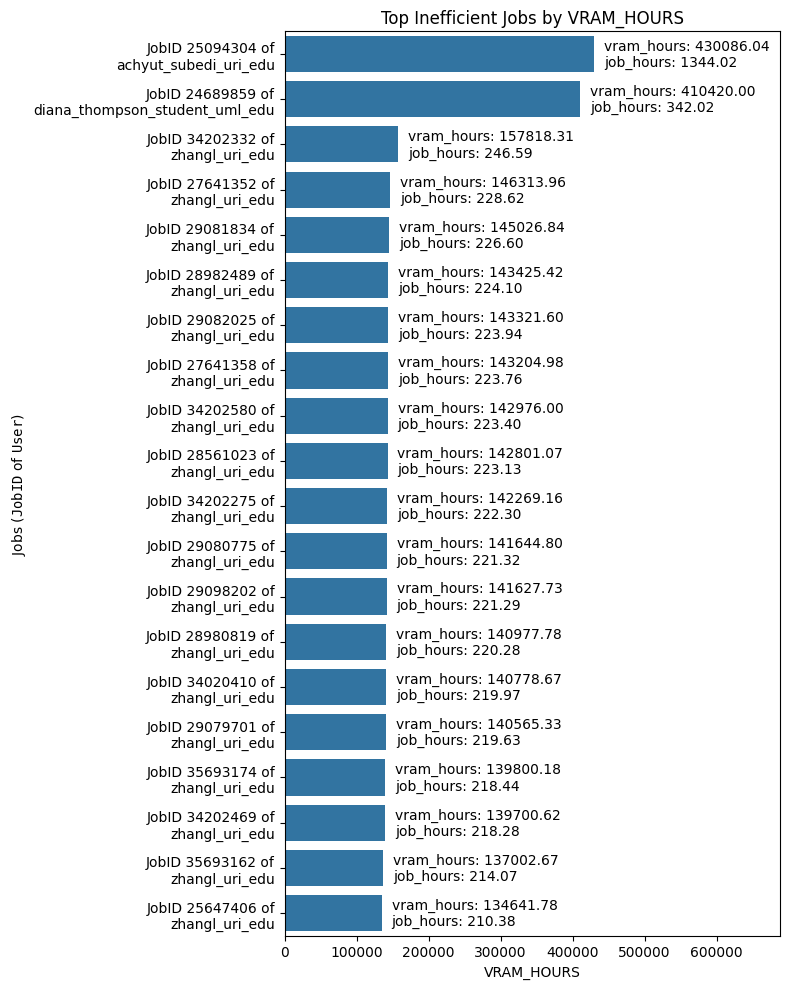

In [10]:
inefficient_jobs_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.JOBS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
    filter_criteria={
        "vram_hours": {"min": 80 * 24, "inclusive": True},  # VRAM-hours threshold for identifying inefficient jobs
    }
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient Jobs by VRAM-hours:")
display(inefficient_jobs_vram_hours.head(10))

# Plot top inefficient jobs by VRAM-hours, with VRAM-hours as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_vram_hours.head(20))
jobs_with_metrics_visualizer.visualize(
    column="vram_hours",
    bar_label_columns=["vram_hours", "job_hours"],
)



### <a id='toc1_2_2_'></a>[User Efficiency Metrics](#toc0_)

In [11]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
0,aaronsun_umass_edu,8,1012.415000,pi_gvanhorn_umass_edu,<NA>,<NA>,0.0,<NA>,272.028236,1.457973e+05
1,aatmakuru_umass_edu,1,4.003889,pi_dhruveshpate_umass_edu,<NA>,<NA>,0.0,<NA>,320.000000,6.406222e+02
2,abdullaharafat_miah_uri_edu,3,24.003611,pi_yu_bi_uri_edu,<NA>,<NA>,0.0,<NA>,80.000000,1.920289e+03
3,abeysck_uri_edu,1,2.000833,pi_hendawi_uri_edu,<NA>,<NA>,0.0,<NA>,80.000000,1.600667e+02
4,absahoo_umass_edu,8,19.606389,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,63.666322,1.248267e+03
...,...,...,...,...,...,...,...,...,...,...
197,yuhongluo_umass_edu,96,693.004722,pi_pgrabowicz_umass_edu,<NA>,<NA>,0.0,<NA>,341.089130,8.128838e+04
198,zeyuanyang_umass_edu,13,13.745556,pi_chuangg_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,1.099644e+03
199,zhangl_uri_edu,119,16573.230000,pi_zhangl_uri_edu,<NA>,<NA>,0.0,<NA>,2236.469745,6.624416e+06
200,zhehuanchen_umass_edu,1,8.000000,pi_chuangg_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,6.400000e+02


#### <a id='toc1_2_2_1_'></a>[Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc0_)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
0,aaronsun_umass_edu,8,1012.415000,pi_gvanhorn_umass_edu,<NA>,<NA>,0.0,<NA>,272.028236,145797.288889
4,absahoo_umass_edu,8,19.606389,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,63.666322,1248.266667
5,achyut_subedi_uri_edu,13,1467.846667,pi_ashgiri_uri_edu,<NA>,<NA>,0.0,<NA>,1267.469445,460731.422222
8,akaruvally_umass_edu,14,9.259167,pi_erietman_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,740.733333
10,amalali_umass_edu,183,402.708889,pi_phaas_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,32216.711111
11,amanbansal_umass_edu,5,108.656944,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,8692.555556
12,amungalpara_umassd_edu,104,1260.148056,pi_mshao_umassd_edu,<NA>,<NA>,0.0,<NA>,822.205063,299758.155556
13,andres_torres_uri_edu,15,110.691111,pi_kelum_gajamannage_uri_edu,<NA>,<NA>,0.0,<NA>,114.721246,10136.400000
14,anijasure_umass_edu,11,79.134167,pi_allan_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,6330.733333
16,anthony_bowers_student_uml_edu,448,3236.678889,pi_subash_sharma_uml_edu,<NA>,<NA>,0.0,<NA>,79.406405,257013.033333


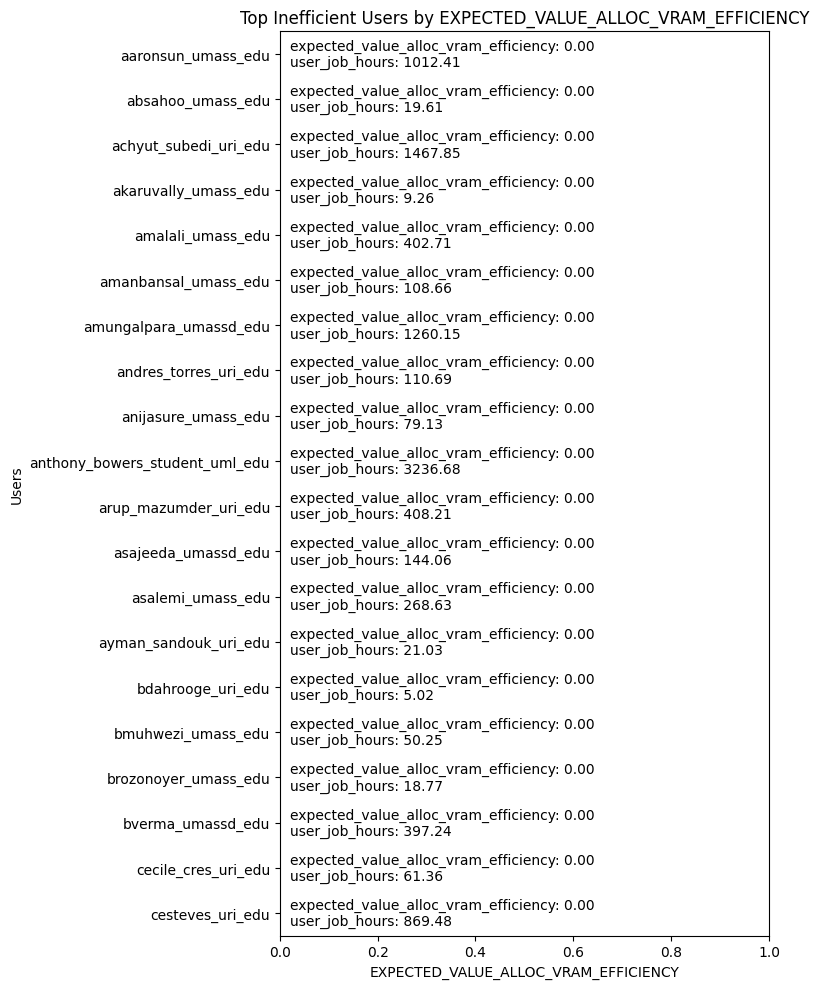

In [12]:
inefficient_users_alloc_vram_eff = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    }
)
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users_alloc_vram_eff.head(20))

# Plot top inefficient users by allocated vram efficiency, with allocated vram efficiency as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_alloc_vram_eff.head(20))
users_with_metrics_visualizer.visualize(
    column="expected_value_alloc_vram_efficiency",
    bar_label_columns=["expected_value_alloc_vram_efficiency", "user_job_hours"],
    figsize=(8, 10)
)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
0,aaronsun_umass_edu,8,1012.415000,pi_gvanhorn_umass_edu,<NA>,<NA>,0.0,<NA>,272.028236,145797.288889
4,absahoo_umass_edu,8,19.606389,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,63.666322,1248.266667
5,achyut_subedi_uri_edu,13,1467.846667,pi_ashgiri_uri_edu,<NA>,<NA>,0.0,<NA>,1267.469445,460731.422222
8,akaruvally_umass_edu,14,9.259167,pi_erietman_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,740.733333
10,amalali_umass_edu,183,402.708889,pi_phaas_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,32216.711111
11,amanbansal_umass_edu,5,108.656944,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,8692.555556
12,amungalpara_umassd_edu,104,1260.148056,pi_mshao_umassd_edu,<NA>,<NA>,0.0,<NA>,822.205063,299758.155556
13,andres_torres_uri_edu,15,110.691111,pi_kelum_gajamannage_uri_edu,<NA>,<NA>,0.0,<NA>,114.721246,10136.400000
14,anijasure_umass_edu,11,79.134167,pi_allan_umass_edu,<NA>,<NA>,0.0,<NA>,80.000000,6330.733333
16,anthony_bowers_student_uml_edu,448,3236.678889,pi_subash_sharma_uml_edu,<NA>,<NA>,0.0,<NA>,79.406405,257013.033333


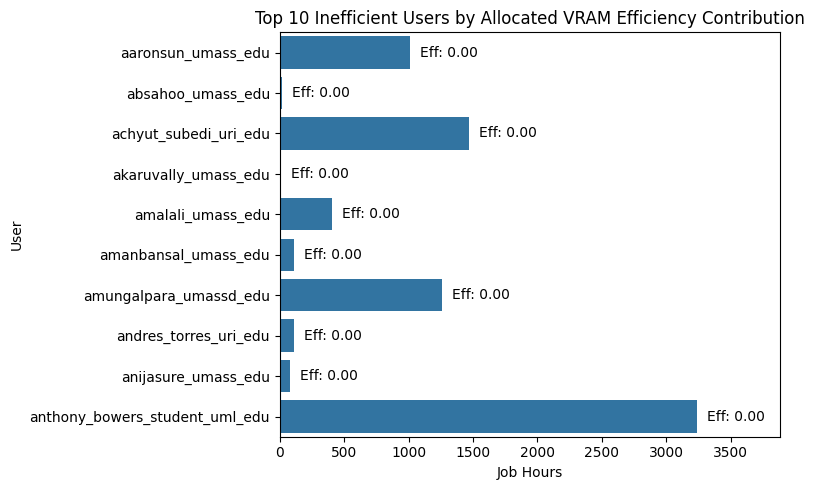

In [13]:
inefficient_users = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    }
)

# Display top inefficient users by job count
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users.head(10))


# Plot top inefficient users by GPU hours, with efficiency as labels
top_users = inefficient_users.head(10)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["user_job_hours"],
    orient="h"
)
plt.xlabel("Job Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by Allocated VRAM Efficiency Contribution")

# Annotate bars with expected_value_alloc_vram_efficiency, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["user_job_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.20 if xmax > 0 else 1
ax.set_xlim(0, xlim)

# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (job_hours, efficiency) in enumerate(
    zip(
        top_users["user_job_hours"],
        top_users["expected_value_alloc_vram_efficiency"],
        strict=True,
    )
):
    # Place annotation at min(job_hours + 2% of xlim, 98% of xlim)
    xpos = min(job_hours + xlim * 0.02, xlim * 0.98)
    # If bar is very close to right spine, nudge annotation left to avoid overlap
    if xpos > xlim * 0.96:
        xpos = xlim * 0.96
    ax.text(
        xpos,
        i,
        f"Eff: {efficiency:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()

#### <a id='toc1_2_2_2_'></a>[Find Inefficient Users based on `vram_hours`](#toc0_)


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
199,zhangl_uri_edu,119,16573.230000,pi_zhangl_uri_edu,<NA>,<NA>,0.0,<NA>,2236.469745,6.624416e+06
156,sdandekar_umass_edu,168,3670.487500,pi_sniekum_umass_edu,<NA>,<NA>,0.0,<NA>,811.093440,8.303329e+05
118,mtasmin_umass_edu,150,2236.724722,pi_annagreen_umass_edu,<NA>,<NA>,0.0,<NA>,955.331318,5.829001e+05
46,dmohapatra_umass_edu,2163,6793.930278,pi_dmohapatra_umass_edu,<NA>,<NA>,0.0,<NA>,80.350488,5.442310e+05
177,tpanambur_umass_edu,8,3334.113333,pi_mparente_umass_edu,<NA>,<NA>,0.0,<NA>,639.663892,5.332980e+05
5,achyut_subedi_uri_edu,13,1467.846667,pi_ashgiri_uri_edu,<NA>,<NA>,0.0,<NA>,1267.469445,4.607314e+05
64,ibrahim_isah_uml_edu,18,763.058889,pi_stephen_lam_uml_edu,<NA>,<NA>,0.0,<NA>,4750.392878,4.601545e+05
134,peihaochen_umass_edu,104,1619.055833,pi_chuangg_umass_edu,<NA>,<NA>,0.0,<NA>,1018.206887,4.333263e+05
12,amungalpara_umassd_edu,104,1260.148056,pi_mshao_umassd_edu,<NA>,<NA>,0.0,<NA>,822.205063,2.997582e+05
16,anthony_bowers_student_uml_edu,448,3236.678889,pi_subash_sharma_uml_edu,<NA>,<NA>,0.0,<NA>,79.406405,2.570130e+05


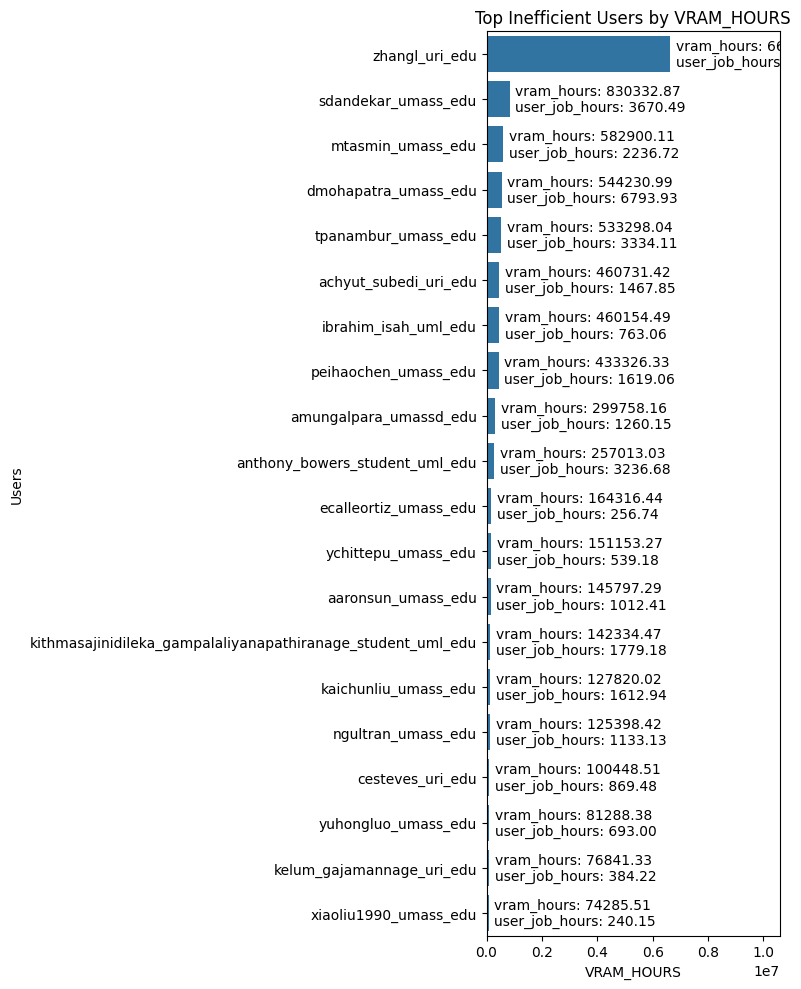

In [14]:
inefficient_users_vram_hours = efficiency_analysis.find_inefficient_users_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(20))


# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_vram_hours.head(20))
users_with_metrics_visualizer.visualize(
    column="vram_hours",
    bar_label_columns=["vram_hours", "user_job_hours"],
    figsize=(8, 10)
)

### <a id='toc1_2_3_'></a>[PI Group Efficiency Metrics](#toc0_)

In [15]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count
0,pi_ameliou_umass_edu,2,16.006111,1,1280.488889,NaN,<NA>,0.0,<NA>,80.000000
1,pi_mpuerrer_uri_edu,1,0.270000,1,21.600000,NaN,<NA>,0.0,<NA>,80.000000
2,pi_juanzhai_umass_edu,113,79.738056,2,6379.044444,NaN,<NA>,0.0,<NA>,80.000000
3,pi_jcrouser_smith_edu,3,38.446667,2,10920.488889,NaN,<NA>,0.0,<NA>,1119.844826
4,pi_jerome_delhommelle_uml_edu,8,1779.180833,1,142334.466667,NaN,<NA>,0.0,<NA>,80.000000
...,...,...,...,...,...,...,...,...,...,...
106,pi_dathomas_uri_edu,1,5.350833,1,428.066667,NaN,<NA>,0.0,<NA>,80.000000
107,pi_hongkunz_umass_edu,1,1.681667,1,269.066667,NaN,<NA>,0.0,<NA>,320.000000
108,pi_clane_uri_edu,1,1.002500,1,80.200000,NaN,<NA>,0.0,<NA>,80.000000
109,pi_zhengqingouy_umass_edu,2,0.589722,1,47.177778,NaN,<NA>,0.0,<NA>,80.000000


#### <a id='toc1_2_3_1_'></a>[Find Inefficient PIs based on `vram_hours`](#toc0_)


Top inefficient PI Groups by VRAM-hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count
61,pi_zhangl_uri_edu,120,16579.237778,2,6.624897e+06,NaN,<NA>,0.0,<NA>,2236.313297
19,pi_sniekum_umass_edu,272,4338.850278,4,1.000962e+06,NaN,<NA>,0.0,<NA>,843.950912
66,pi_annagreen_umass_edu,295,2634.008056,4,6.158257e+05,NaN,<NA>,0.0,<NA>,908.993490
45,pi_dmohapatra_umass_edu,2163,6793.930278,1,5.442310e+05,NaN,<NA>,0.0,<NA>,80.350488
44,pi_mparente_umass_edu,8,3334.113333,1,5.332980e+05,NaN,<NA>,0.0,<NA>,639.663892
23,pi_ashgiri_uri_edu,17,1591.745000,3,4.896211e+05,NaN,<NA>,0.0,<NA>,1420.662261
93,pi_mshao_umassd_edu,402,3432.445278,6,4.735419e+05,NaN,<NA>,0.0,<NA>,549.825384
85,pi_stephen_lam_uml_edu,22,827.094444,2,4.704002e+05,NaN,<NA>,0.0,<NA>,4653.895408
68,pi_chuangg_umass_edu,148,1763.375556,9,4.443929e+05,NaN,<NA>,0.0,<NA>,994.918934
96,pi_subash_sharma_uml_edu,448,3236.678889,1,2.570130e+05,NaN,<NA>,0.0,<NA>,79.406405


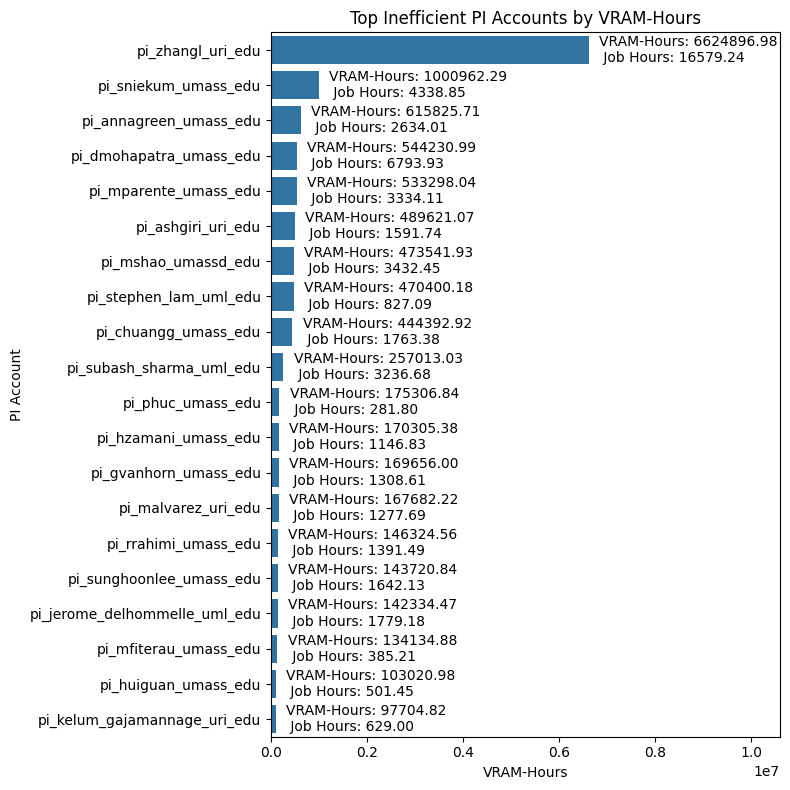

In [16]:
inefficient_pis_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.PI_GROUPS,
    sorting_key="pi_acc_vram_hours",
    ascending=False,
    filter_criteria={
        "pi_acc_vram_hours": {"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a PI account
    }
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-hours:")
display(inefficient_pis_vram_hours.head(20))

top_pi_accounts = inefficient_pis_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_pi_accounts["pi_account"],
    x=top_pi_accounts["pi_acc_vram_hours"],
    order=top_pi_accounts["pi_account"].tolist(),  # Only show present values
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("PI Account")
plt.title("Top Inefficient PI Accounts by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_pi_accounts["pi_acc_vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, pi_acc_job_hours) in enumerate(
    zip(
        top_pi_accounts["pi_acc_vram_hours"],
        top_pi_accounts["pi_acc_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {pi_acc_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Example: Analyze all jobs with no VRAM constraints](#toc0_)

In [17]:
# Filter jobs where no VRAM constraint was set but a GPU was allocated
no_vram_constraint_efficiency_analysis = ea.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)
all_no_vram_constraint_jobs = no_vram_constraint_efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter={"min": 0, "inclusive": False},  # No VRAM constraints
    gpu_count_filter={"min": 1, "inclusive": True},  # At least one GPU allocated
    gpu_mem_usage_filter={"min": 0, "inclusive": False}  # Used more than 0 GiB of VRAM
)

display(all_no_vram_constraint_jobs.head(10))
print(all_no_vram_constraint_jobs.shape)

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
1,38750103,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,...,400.0,4.025245e+11,18.408882,0 days 00:00:09,320,320,320,320,307,1900
4,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,80,80,64,5661
8,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,77.0,3.440394e+08,98.004761,0 days 00:00:28,40,<NA>,40,80,43775,43775
10,38778439,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,74.0,3.487375e+08,99.940666,0 days 00:00:23,40,<NA>,40,40,43775,43775
11,38778453,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,...,200.0,3.774736e+11,12.098560,0 days 00:00:02,160,160,160,160,307,1900
12,38779093,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,75.0,3.485778e+08,99.922623,0 days 00:00:28,40,<NA>,40,40,43775,43775
13,38779171,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,76.0,3.461448e+08,99.899124,0 days 00:00:30,40,<NA>,40,40,43775,43775
15,38779276,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,76.0,2.885714e+08,99.891739,0 days 00:00:09,40,<NA>,40,40,43775,43775
17,38779546,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,73.0,2.495939e+08,99.897453,0 days 00:00:22,40,<NA>,40,40,43775,43775
18,38780091,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,...,73.0,2.485330e+08,99.933105,0 days 00:00:07,40,<NA>,40,40,43775,43775


(112985, 33)


### <a id='toc1_3_1_'></a>[Job Efficiency Metrics](#toc0_)

In [18]:
no_vram_constraint_jobs_with_metrics = no_vram_constraint_efficiency_analysis.calculate_job_efficiency_metrics(
    all_no_vram_constraint_jobs
    )

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(no_vram_constraint_jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
1,38750103,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,TIMEOUT,SUCCESS,2025-06-26 16:21:10,2025-06-26 16:21:19,0 days 08:00:21,0 days 00:08:00,superpod-a100,[gpu015],16,4,{'a100': 4},3.299974e+11,400.0,18.408882,0 days 00:00:09,320,320,320,320,307,1900,32.023333,10247.466667,307.333984,0.960419,0.960419,-413.853600,-413.8536,374.880127,500.0,0.749760
4,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,TIMEOUT,SUCCESS,2025-06-26 18:16:35,2025-06-26 18:17:01,0 days 08:00:10,0 days 00:08:00,superpod-a100,[gpu013],8,1,{'a100': 1},1.525049e+10,27.0,3.993254,0 days 00:00:26,40,80,80,80,64,5661,8.002778,640.222222,14.203125,0.177539,0.355078,-1106.665485,-662.897256,103.428574,200.0,0.517143
8,38777804,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 22:16:01,2025-06-26 22:16:29,0 days 01:44:01,0 days 00:02:00,gpu-preempt,[gpu018],1,1,{'a100': 1},5.054136e+08,77.0,98.004761,0 days 00:00:28,40,<NA>,40,80,43775,43775,1.733611,138.688889,0.470703,0.005884,0.011768,-712.244323,-616.112511,0.320412,8.0,0.040051
10,38778439,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 22:48:02,2025-06-26 22:48:25,0 days 01:46:21,0 days 00:02:00,gpu-preempt,[ece-gpu001],1,1,{'a100': 1},5.054136e+08,74.0,99.940666,0 days 00:00:23,40,<NA>,40,40,43775,43775,1.772500,70.900000,0.470703,0.011768,0.011768,-314.966667,-314.966667,0.324787,8.0,0.040598
11,38778453,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,COMPLETED,SUCCESS,2025-06-26 22:54:11,2025-06-26 22:54:13,0 days 02:42:59,0 days 00:08:00,superpod-a100,[gpu018],16,2,{'a100': 2},1.658617e+11,200.0,12.098560,0 days 00:00:02,160,160,160,160,307,1900,5.432778,869.244444,154.470703,0.965442,0.965442,-30.570771,-30.570771,351.549713,500.0,0.703099
12,38779093,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:01:42,2025-06-26 23:02:10,0 days 01:43:21,0 days 00:02:00,gpu-preempt,[ece-gpu002],1,1,{'a100': 1},5.054136e+08,75.0,99.922623,0 days 00:00:28,40,<NA>,40,40,43775,43775,1.722500,68.900000,0.470703,0.011768,0.011768,-306.081852,-306.081852,0.324638,8.0,0.040580
13,38779171,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:11:47,2025-06-26 23:12:17,0 days 01:38:59,0 days 00:02:00,gpu-preempt,[ece-gpu001],1,1,{'a100': 1},5.054136e+08,76.0,99.899124,0 days 00:00:30,40,<NA>,40,40,43775,43775,1.649722,65.988889,0.470703,0.011768,0.011768,-293.149512,-293.149512,0.322372,8.0,0.040297
15,38779276,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:24:17,2025-06-26 23:24:26,0 days 00:46:49,0 days 00:00:59,gpu-preempt,[ece-gpu002],1,1,{'a100': 1},4.970250e+08,76.0,99.891739,0 days 00:00:09,40,<NA>,40,40,43775,43775,0.780278,31.211111,0.462891,0.011572,0.011572,-139.174837,-139.174837,0.268753,8.0,0.033594
17,38779546,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,"['a100', 'v100']",normal,COMPLETED,SUCCESS,2025-06-26 23:36:13,2025-06-26 23:36:35,0 days 00:43:47,0 days 00:00:59,gpu-preempt,[ece-gpu001],1,1,{'a100': 1},4.78150

Jobs found: 112985


#### <a id='toc1_3_1_1_'></a>[Problem with duplicate JobIDs](#toc0_)

In [19]:
# select jobs with specific job id
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics[no_vram_constraint_jobs_with_metrics["JobID"] == 24374463])
pd.reset_option('display.max_columns')

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
289381,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-09-03 15:33:56,2024-09-04 02:12:01,0 days 02:08:20,0 days 02:48:00,gpu-preempt,"[gpu018, gpu019]",224,16,{'a100': 16},6.174015e+09,99.0,1.398886,0 days 10:38:05,640,<NA>,640,1280,21,34,34.222222,4.380444e+04,5.75,0.004492,0.008984,-2.367812e+05,-206418.295898,57.617062,512.0,0.112533
289714,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-29 20:02:59,2024-08-31 13:08:52,3 days 02:24:57,0 days 02:48:00,gpu-preempt,"[gpu014, gpu018]",224,16,{'a100': 16},6.174015e+09,100.0,1.425578,1 days 17:05:53,640,<NA>,640,1280,21,34,1190.653333,1.524036e+06,5.75,0.004492,0.008984,-8.238049e+06,-7181667.820298,57.735668,512.0,0.112765
290908,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-28 00:04:02,2024-08-28 12:01:14,1 days 08:01:37,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,{'a100': 16},6.174015e+09,100.0,1.419882,0 days 11:57:12,640,<NA>,640,1280,21,34,512.431111,6.559118e+05,5.75,0.004492,0.008984,-3.545476e+06,-3090832.501584,57.736538,512.0,0.112767
291327,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-23 20:50:50,2024-08-24 05:52:24,3 days 18:11:35,0 days 02:48:00,gpu-preempt,"[gpu017, gpu020]",224,16,{'a100': 16},6.174015e+09,100.0,1.419324,0 days 09:01:34,640,<NA>,640,1280,21,34,1443.088889,1.847154e+06,5.75,0.004492,0.008984,-9.984634e+06,-8704284.232043,57.648254,512.0,0.112594
292548,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-21 15:08:27,2024-08-22 12:51:25,1 days 07:59:17,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,{'a100': 16},6.174015e+09,100.0,1.420042,0 days 21:42:58,640,<NA>,640,1280,21,34,511.808889,6.551154e+05,5.75,0.004492,0.008984,-3.541171e+06,-3087079.441659,57.734287,512.0,0.112762
293301,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-20 16:15:30,2024-08-21 10:14:09,0 days 04:54:10,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,{'a100': 16},6.174015e+09,99.0,1.427450,0 days 17:58:39,640,<NA>,640,1280,21,34,78.444444,1.004089e+05,5.75,0.004492,0.008984,-5.427518e+05,-473153.626313,57.712429,512.0,0.112720


#### <a id='toc1_3_1_2_'></a>[Top users with most number of jobs that have no VRAM constraints](#toc0_)

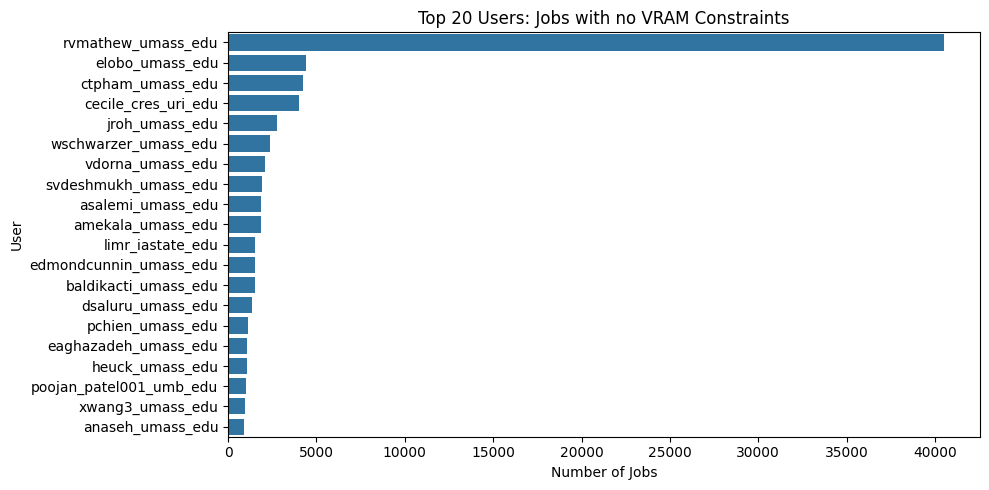

In [20]:
# Plot top users by number of jobs with no VRAM constraints
if not all_no_vram_constraint_jobs.empty:
    plt.figure(figsize=(10, 5))
    user_counts = all_no_vram_constraint_jobs["User"].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient="h")
    plt.xlabel("Number of Jobs")
    plt.ylabel("User")
    plt.title("Top 20 Users: Jobs with no VRAM Constraints")
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found without VRAM constraints.")

#### <a id='toc1_3_1_3_'></a>[Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc0_)


Top inefficient Jobs by allocated VRAM efficiency score:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
291327,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,1443.088889,1.847154e+06,5.750000,0.004492,0.008984,-9.984634e+06,-8704284.232043,57.648254,512.0,0.112594
289714,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,1190.653333,1.524036e+06,5.750000,0.004492,0.008984,-8.238049e+06,-7181667.820298,57.735668,512.0,0.112765
296545,24009623,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,...,590.542222,7.558940e+05,5.728516,0.004475,0.008951,-4.088751e+06,-3564805.182063,45.587269,512.0,0.089038
290908,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,512.431111,6.559118e+05,5.750000,0.004492,0.008984,-3.545476e+06,-3090832.501584,57.736538,512.0,0.112767
292548,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,511.808889,6.551154e+05,5.750000,0.004492,0.008984,-3.541171e+06,-3087079.441659,57.734287,512.0,0.112762
16770,37751772,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,768.080000,9.831424e+05,54.638672,0.042686,0.042686,-3.100707e+06,-3100706.711723,12.704948,176.0,0.072187
16769,37750425,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,768.115556,9.831879e+05,54.814453,0.042824,0.042824,-3.097692e+06,-3097692.254144,12.604267,176.0,0.071615
16225,37749568,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,745.924444,9.547833e+05,54.603516,0.042659,0.042659,-3.011880e+06,-3011880.199659,12.703892,176.0,0.072181
293050,24374462,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,1082.040000,6.925056e+05,8.451172,0.013205,0.02641,-2.996585e+06,-2516576.34781,57.801441,512.0,0.112893
16536,37752650,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,338.093333,4.327595e+05,1.947266,0.001521,0.001521,-2.807825e+06,-2807825.303014,4.486153,176.0,0.025490


Minimum value for alloc_vram_efficiency_score: -9984633.665170714


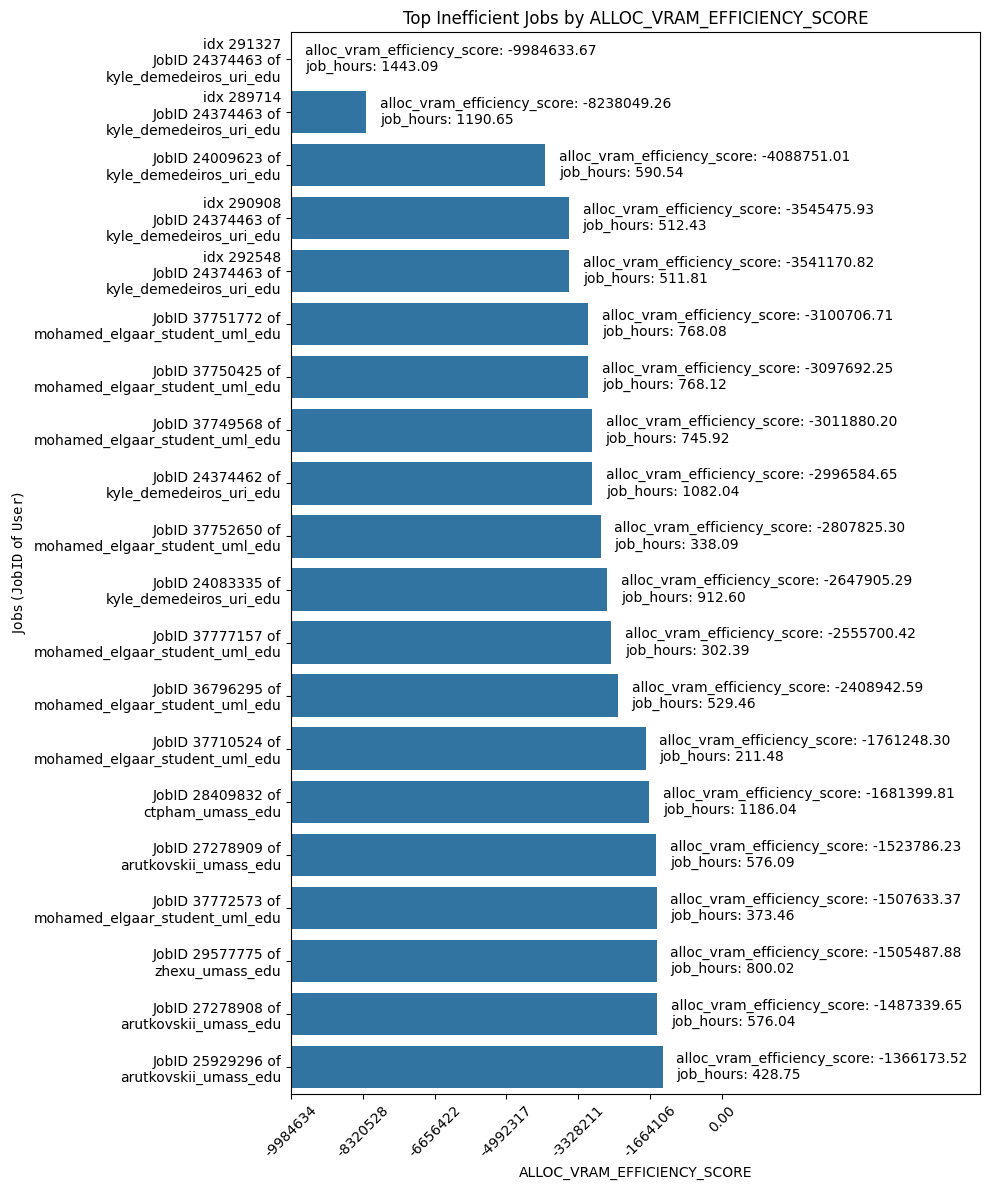

In [21]:
low_alloc_vram_score_jobs = no_vram_constraint_efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.JOBS,
    sorting_key="alloc_vram_efficiency_score",
    ascending=True,  # Sort by alloc_vram_efficiency_score in ascending order
    filter_criteria={
        "alloc_vram_efficiency_score": {"max": -10, "inclusive": True},  # score threshold
    }
)
# Display top inefficient users by alloc_vram_efficiency_score
print("\nTop inefficient Jobs by allocated VRAM efficiency score:")

display(low_alloc_vram_score_jobs.head(20))

jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(low_alloc_vram_score_jobs.head(20))
jobs_with_metrics_visualizer.visualize(
    column="alloc_vram_efficiency_score",
    bar_label_columns=["alloc_vram_efficiency_score", "job_hours"],
    figsize=(10, 12)
)

Aggregate by Job Metrics 

In [22]:
efficiency_analysis.compare_job_metrics_by_gpu_type()

c:\Users\Nitya Karthik A\anaconda3\envs\duckdb\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,A100,H100,L40S,A40,RTX_8000,V100
Mean Used GPU Memory (GiB),17.201086,23.612871,15.308789,14.592507,11.920573,0.0
Median Used GPU Memory (GiB),1.433594,6.951172,14.483398,5.158203,0.000000,0.0
Mean Requested VRAM Efficiency,0.343544,0.577145,0.128362,0.144738,0.223511,<NA>
Median Requested VRAM Efficiency,0.037024,0.346313,0.132782,0.062634,0.223511,<NA>
Mean Allocated VRAM Efficiency,0.195782,0.294564,0.133127,0.166261,0.064786,0.0
Median Allocated VRAM Efficiency,0.017920,0.086890,0.082292,0.046122,0.000000,0.0
Total GPU Hours,881896.701667,8414.887500,61.071111,214.556667,11.031111,3.21
Mean Weighted VRAM Efficiency,0.218726,0.308970,0.156660,0.110912,0.183081,0.0
Median Weighted VRAM Efficiency,0.011647,0.096909,0.067183,0.006944,0.000000,0.0


In [23]:
print(efficiency_analysis.jobs_with_efficiency_metrics['GPUType'].apply(type).value_counts())
print(efficiency_analysis.jobs_with_efficiency_metrics['GPUType'].head(10).tolist())

efficiency_analysis.compare_gpu_utilization_patterns()

GPUType
<class 'dict'>    237560
Name: count, dtype: int64
[{'a100': 4}, {'a100': 4}, {'a100': 1}, {'a100': 1}, {'a100': 1}, {'a100': 1}, {'a100': 1}, {'a100': 1}, {'a100': 1}, {'a100': 1}]


c:\Users\Nitya Karthik A\anaconda3\envs\duckdb\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,GPU Type,Mean Used GPU Memory (GiB),Median Used GPU Memory (GiB),Mean Requested VRAM Efficiency,Median Requested VRAM Efficiency,Mean Allocated VRAM Efficiency,Median Allocated VRAM Efficiency,Total GPU Hours,Mean Weighted VRAM Efficiency,Median Weighted VRAM Efficiency
A100,A100,17.201086,1.433594,0.343544,0.037024,0.195782,0.01792,881896.701667,0.218726,0.011647
H100,H100,23.612871,6.951172,0.577145,0.346313,0.294564,0.08689,8414.8875,0.30897,0.096909
A40,A40,14.592507,5.158203,0.144738,0.062634,0.166261,0.046122,214.556667,0.110912,0.006944
L40S,L40S,15.308789,14.483398,0.128362,0.132782,0.133127,0.082292,61.071111,0.15666,0.067183
RTX_8000,RTX_8000,11.920573,0.0,0.223511,0.223511,0.064786,0.0,11.031111,0.183081,0.0
V100,V100,0.0,0.0,<NA>,<NA>,0.0,0.0,3.21,0.0,0.0
